In [2]:
import numpy as np
import numpy.linalg as npla
import numpy.fft as fft
import matplotlib.pyplot as plt
import scipy.optimize
import os

shape of flow data:   (1, 4, 1, 256, 256)
vmax:                 1.0
venc:                 1.0
venc (factor):        1.0


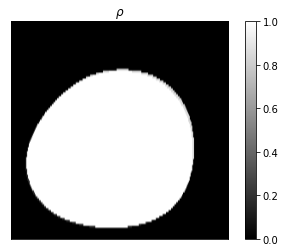

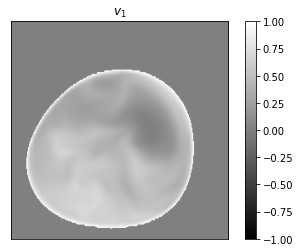

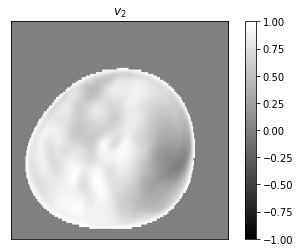

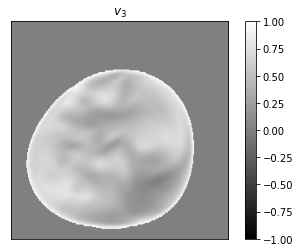

In [3]:
# Load image
flow_data = np.load('../../runs/03_idealaorta/imgs_n1.npy')
imshape = (flow_data.shape[3], flow_data.shape[4])
print('shape of flow data:  ', flow_data.shape)
# Get vmax
vmax = np.max(np.abs(flow_data[0, 1::, 0, :, :]))
print('vmax:                ', vmax)
# Set venc
venc = 1.0 * vmax
print('venc:                ', venc)
print('venc (factor):       ', venc/vmax)
# Get complex images
Xo = flow_data[0, 0, 0, :, :]
Xi = flow_data[0, 0, 0, :, :] * np.exp(1j * np.pi * flow_data[0, 1, 0, :, :] / venc)
Xj = flow_data[0, 0, 0, :, :] * np.exp(1j * np.pi * flow_data[0, 2, 0, :, :] / venc)
Xk = flow_data[0, 0, 0, :, :] * np.exp(1j * np.pi * flow_data[0, 3, 0, :, :] / venc)

Xim = [ Xo, Xi, Xj, Xk ]

plt.imshow(flow_data[0, 0, 0, :, :], vmin=0.0, vmax=1.0,aspect='equal', origin='lower', cmap='gray')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$\\rho$')
plt.show()

for I in range(1, 4):
    plt.imshow(flow_data[0, I, 0, :, :], vmin=-vmax, vmax=+vmax, aspect='equal', origin='lower', cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$v_{{{:d}}}$'.format(I))
    plt.show()

## Reconstruction

In [4]:
# Sampling fraction
delta = 0.25

### Bernoulli mask

In [30]:
# Sampling set
#   Bernoulli does not need fftshift
S = np.where(np.random.uniform(size=imshape) <= delta, True, False)
# Colormap
cmap = 'gray'

Mask sample

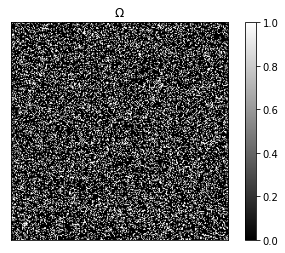

In [31]:
plt.imshow(S, vmin=0.0, vmax=1.0, aspect='equal', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$\Omega$')
plt.show()

Expected value of the reconstructed images over the noise conditioned on the mask

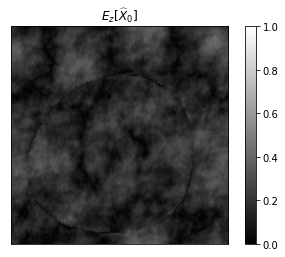

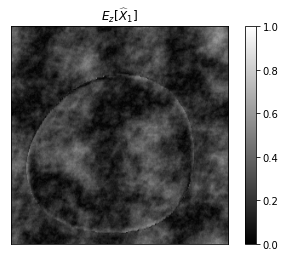

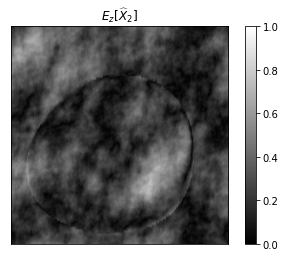

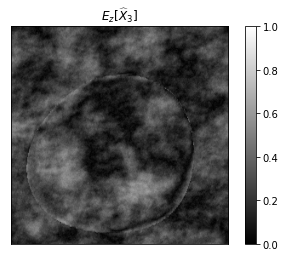

In [32]:
EXim = []
for I in range(4):
    EXim.append(fft.ifft2(S * fft.fft2(Xim[I], norm='ortho'), norm='ortho'))

plt.imshow(np.abs(EXim[0]), vmin=0.0, vmax=1.0, aspect='equal', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$E_{{z}}[\widehat{{X}}_0]$')
plt.show()

for I in range(1, 4):
    plt.imshow(np.abs(EXim[I]), vmin=0.0, vmax=1.0, aspect='equal', origin='lower', cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$E_{{z}}[\widehat{{X}}_{{{:d}}}]$'.format(I))
    plt.show()

Covariance kernel over the noise conditioned on the mask

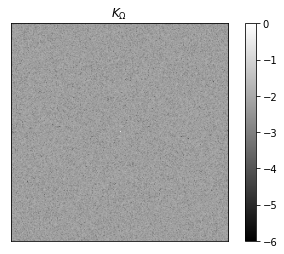

In [33]:
K = fft.fftshift(fft.ifft2(S)) / delta

plt.imshow(np.log10(np.abs(K)), aspect='equal', origin='lower', cmap=cmap, vmin=-6, vmax=0)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$K_{\Omega}$')
plt.show()

Expectation over the mask and noise

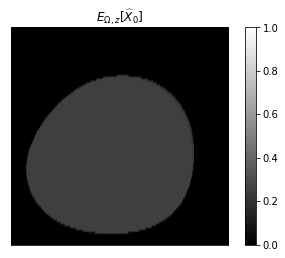

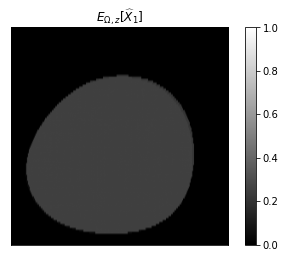

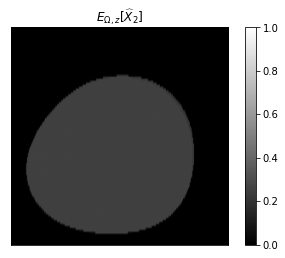

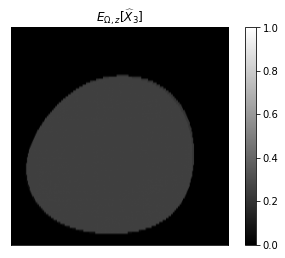

In [34]:
EXim = []
for I in range(4):
    EXim.append(fft.ifft2(delta * fft.fft2(Xim[I], norm='ortho'), norm='ortho'))

plt.imshow(np.abs(EXim[0]), vmin=0.0, vmax=1.0, aspect='equal', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$E_{{\Omega, z}}[\widehat{{X}}_0]$')
plt.show()

for I in range(1, 4):
    plt.imshow(np.abs(EXim[I]), vmin=0.0, vmax=1.0, aspect='equal', origin='lower', cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$E_{{\Omega, z}}[\widehat{{X}}_{{{:d}}}]$'.format(I))
    plt.show()

Covariance kernel over the noise and the mask

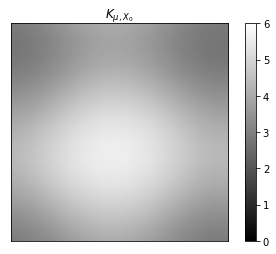

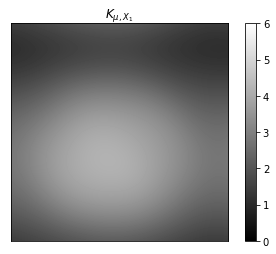

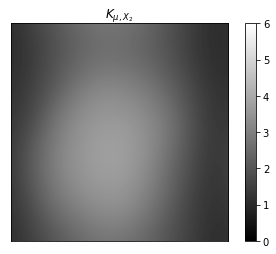

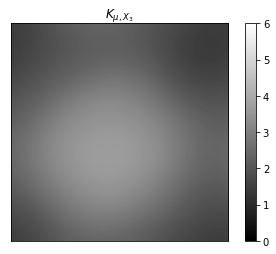

In [35]:
KXim = []
for I in range(4):
    W = delta * (1 - delta) * np.abs(fft.fft2(Xim[I], norm='ortho')) ** 2 / np.sqrt(np.prod(imshape))
    KXim.append(fft.ifft2(W * fft.fft2(Xim[I], norm='ortho'), norm='ortho'))

plt.imshow(np.abs(KXim[0]), aspect='equal', origin='lower', cmap=cmap, vmin=0, vmax=6)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$K_{{\mu, X_0}}$')
plt.show()

for I in range(1, 4):
    plt.imshow(np.abs(KXim[I]), aspect='equal', origin='lower', cmap=cmap, vmin=0, vmax=6)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$K_{{\mu, X_{{{:d}}}}}$'.format(I))
    plt.show()


### Gaussian mask

In [37]:
# Sampling set
kx = np.linspace(0, imshape[0] - 1, imshape[0])
kx = fft.fftshift(np.where(kx < imshape[0] // 2, kx, kx - imshape[0]))
ky = np.linspace(0, imshape[1] - 1, imshape[1])
ky = fft.fftshift(np.where(ky < imshape[1] // 2, ky, ky - imshape[1]))
[ kx, ky ] = np.meshgrid(kx, ky)
f = lambda t : delta - np.sum(np.exp(-t * (kx ** 2 + ky ** 2)).ravel()) / (imshape[0] * imshape[1])
tsamp, rnfo = scipy.optimize.toms748(f, 1E-6, 1E+6, xtol=1E-6, full_output=True, disp=True)

W = np.exp(-tsamp * (kx ** 2 + ky ** 2))
S = np.where(np.random.uniform(size=imshape) <= W, True, False)
S = fft.fftshift(S) 
# Colormap
cmap = 'gray'

Mask sample

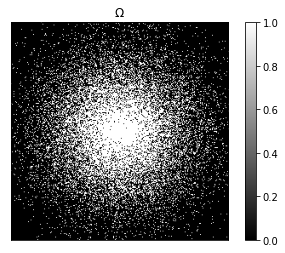

In [38]:
plt.imshow(fft.ifftshift(S), vmin=0.0, vmax=1.0, aspect='equal', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$\Omega$')
plt.show()

Expected value of the reconstructed images over the noise conditioned on the mask

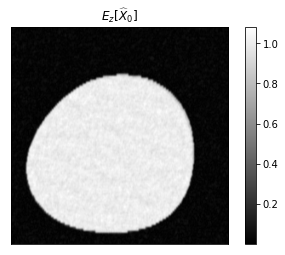

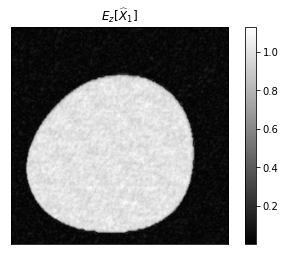

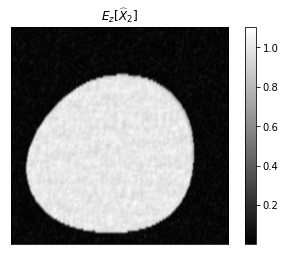

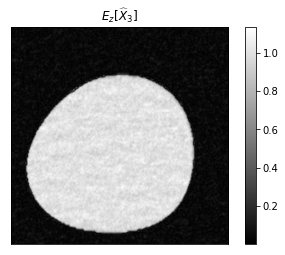

In [39]:
EXim = []
for I in range(4):
    EXim.append(fft.ifft2(S * fft.fft2(Xim[I], norm='ortho'), norm='ortho'))

plt.imshow(np.abs(EXim[0]), aspect='equal', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$E_{{z}}[\widehat{{X}}_0]$')
plt.show()

for I in range(1, 4):
    plt.imshow(np.abs(EXim[I]), aspect='equal', origin='lower', cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$E_{{z}}[\widehat{{X}}_{{{:d}}}]$'.format(I))
    plt.show()


Covariance kernel over the noise conditioned on the mask

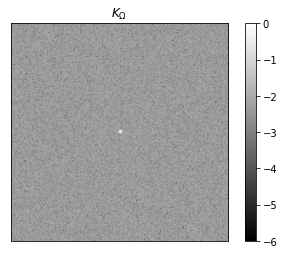

In [40]:
K = fft.fftshift(fft.ifft2(S))
K = K / np.abs(K).max()

plt.imshow(np.log10(np.abs(K)), aspect='equal', origin='lower', cmap=cmap, vmin=-6, vmax=0)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$K_{\Omega}$')
plt.show()

Expectation over the mask and noise

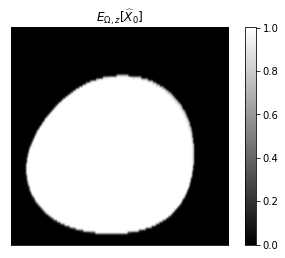

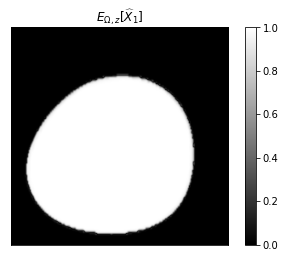

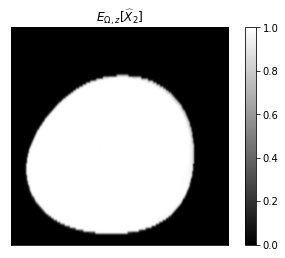

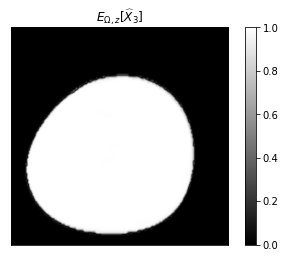

In [41]:
EXim = []
for I in range(4):
    EXim.append(fft.ifft2(fft.fftshift(W) * fft.fft2(Xim[I], norm='ortho'), norm='ortho'))

plt.imshow(np.abs(EXim[0]), aspect='equal', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$E_{{\Omega, z}}[\widehat{{X}}_0]$')
plt.show()

for I in range(1, 4):
    plt.imshow(np.abs(EXim[I]), aspect='equal', origin='lower', cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$E_{{\Omega, z}}[\widehat{{X}}_{{{:d}}}]$'.format(I))
    plt.show()


Covariance kernel over the noise and the mask

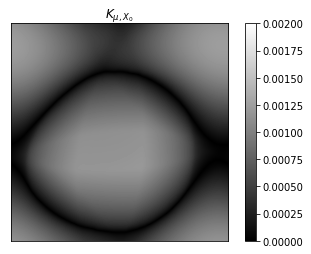

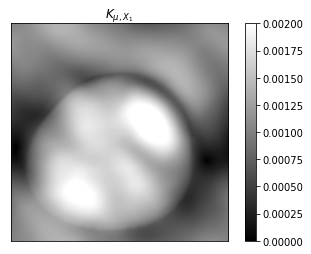

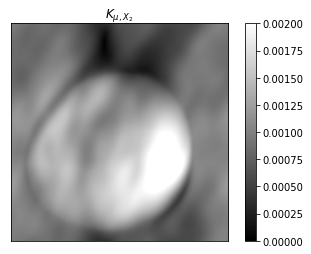

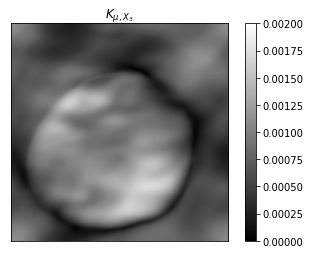

In [42]:
KXim = []

for I in range(4):
    _W = fft.fftshift(W * (1 - W)) * np.abs(fft.fft2(Xim[I], norm='ortho')) ** 2 / np.sqrt(np.prod(imshape))
    KXim.append(fft.ifft2(_W * fft.fft2(Xim[I], norm='ortho'), norm='ortho'))

plt.imshow(np.abs(KXim[0]), aspect='equal', origin='lower', cmap=cmap, vmin=0, vmax=0.002)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('$K_{{\mu, X_0}}$')
plt.show()

for I in range(1, 4):
    plt.imshow(np.abs(KXim[I]), aspect='equal', origin='lower', cmap=cmap, vmin=0, vmax=0.002)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('$K_{{\mu, X_{{{:d}}}}}$'.format(I))
    plt.show()